## Ejercicios Clase II y III 

In [14]:
import numpy as np
import pandas as pd
from model_2 import *
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

def split(data, percentage):  # 0.8
    # Set X & y
    X = data[:, :data.shape[1]-1]
    y = data[:, data.shape[1]-1]

    # X.shape[0] -> 10 (filas)

    permuted_idxs = np.random.permutation(X.shape[0])
    # 2,1,3,4,6,7,8,5,9,0

    train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
    # permuted_idxs[0:8]
    # [2,1,3,4,5,6,7,8,5]

    test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
    # [9,0]

    X_train = X[train_idxs]
    X_test = X[test_idxs]

    y_train = y[train_idxs]
    y_test = y[test_idxs]

    return X_train, X_test, y_train, y_test

class Layer(object):
    def __init__(self, units=1):
        self.units = units
    def forward(self):
        NotImplemented
    def back(self):
        NotImplemented
    def update(self):
        NotImplemented
class fully_connected(Layer):
    def forward(self, X, W, b):
        Z = W.T @ X + b
        A = sigmoid(Z)
        return A, Z
    def back(self, dZ, W, A, A_ant, batch_size):
        dZ_ant = W @ dZ * A * (1 - A)
        dW_ant = 1/batch_size * dZ_ant @ A_ant.T
        db_ant = 1/batch_size * np.sum(dZ_ant, axis=1, keepdims=True)
        return dW_ant, db_ant, dZ_ant
    def update(self, W, dW, b, db, lr):
        W = W - lr * dW
        b = b - lr * db
        return W, b
class binary_output(Layer):
    def forward(self, A, W, b):
        Z = W.T @ A + b
        y_hat = sigmoid(Z)
        return y_hat, Z
    def back(self, Z, A, y_hat, batch_Y, batch_size):
        dZ = -2 * (batch_Y - y_hat) * sigmoid(Z) * (1 - sigmoid(Z))
        dW = 1/batch_size * dZ @ A.T
        db = 1/batch_size * np.sum(dZ, axis=1, keepdims=True)
        return dW, db, dZ
    def update(self, W, dW, b, db, lr):
        W = W - lr * dW
        b = b - lr * db
        return W, b

class nn(object):
    def __init__(self, nnet):
        self.nnet = nnet
        self.W = []
        self.b = []
        self.J = []
        self.J_val = [] # Permite acumular la función costo para el set de validación

    def fit(self, X, Y, X_val, Y_val, n_epochs=100, batch_size=15, lr = 0.001):
        self.W.append(np.ones(1))
        self.b.append(np.ones(1))
        for layer in range(1, len(self.nnet)):
            self.W.append(np.random.random(size=(self.nnet[layer-1].units, self.nnet[layer].units)))
            self.b.append(np.random.random(size=(self.nnet[layer].units, 1)))

        for i in range(n_epochs):
            err_train_ep = 0
            for j in range(0, len(X), batch_size):
                end = j + batch_size if j + batch_size <= len(X) else len(X)
                batch_X = X[j: end]
                batch_Y = Y[j: end].reshape(-1, 1)

                ## Forward Propagation ##
                a1,z1 = self.nnet[1].forward(batch_X.T, self.W[1], self.b[1])
                a2,z2 = self.nnet[2].forward(a1, self.W[2], self.b[2])
                y_hat,z3 = self.nnet[3].forward(a2, self.W[3], self.b[3])

                ## Backward Propagation ##
                dW3, db3, dZ3 = self.nnet[3].back(z3, a2, y_hat, batch_Y.T, batch_size)
                dW2, db2, dZ2 = self.nnet[2].back(dZ3, self.W[3], a2, a1, batch_size)
                dW1, db1, dZ1 = self.nnet[2].back(dZ2, self.W[2], a1 ,batch_X.T, batch_size)


                ## Update ##
                self.W[3], self.b[3] = self.nnet[3].update(self.W[3], dW3.T, self.b[3], db3, lr)
                self.W[2], self.b[2] = self.nnet[2].update(self.W[2], dW2.T, self.b[2], db2, lr)
                self.W[1], self.b[1] = self.nnet[1].update(self.W[1], dW1.T, self.b[1], db1, lr)

                ## Cost Function per epoch  ##
                err_train_ep += np.sum(np.power(batch_Y.T - y_hat, 2))

            self.J.append(err_train_ep/X_train.shape[0])
            self.J_val.append(self.predict(X_val, Y_val))

        return self.W, self.b, self.J, self.J_val


    def predict(self, X, Y):
        ## Forward Propagation ##
        a1, z1 = self.nnet[1].forward(X.T, self.W[1], self.b[1])
        a2, z2 = self.nnet[2].forward(a1, self.W[2], self.b[2])
        y_hat, z3 = self.nnet[3].forward(a2, self.W[3], self.b[3])
        J = np.sum(np.power(Y.T - y_hat, 2))/len(Y)
        return J


Train on 720 samples, validate on 180 samples
Epoch 1/50
720/720 [==============================] - 0s 329us/step - loss: 0.4397 - accuracy: 0.5528 - val_loss: 0.3597 - val_accuracy: 0.8389
Epoch 2/50
720/720 [==============================] - 0s 185us/step - loss: 0.3317 - accuracy: 0.8514 - val_loss: 0.2822 - val_accuracy: 0.8611
Epoch 3/50
720/720 [==============================] - 0s 192us/step - loss: 0.2647 - accuracy: 0.8639 - val_loss: 0.2344 - val_accuracy: 0.8667
Epoch 4/50
720/720 [==============================] - 0s 218us/step - loss: 0.2235 - accuracy: 0.8625 - val_loss: 0.2065 - val_accuracy: 0.8611
Epoch 5/50
720/720 [==============================] - 0s 194us/step - loss: 0.1989 - accuracy: 0.8653 - val_loss: 0.1887 - val_accuracy: 0.8556
Epoch 6/50
720/720 [==============================] - 0s 199us/step - loss: 0.1810 - accuracy: 0.8708 - val_loss: 0.1793 - val_accuracy: 0.8611
Epoch 7/50
720/720 [==============================] - 0s 206us/step - loss: 0.1692 - accur

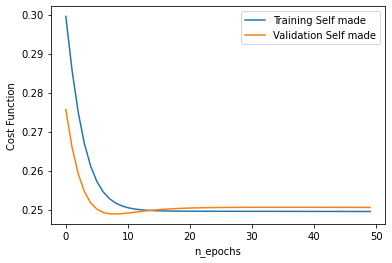

Pesos Self Made NN
W1 : [[0.2400498  0.95090212 0.78231422]
 [0.8022898  0.83769313 0.14880702]]
W2 : [[0.09187879 0.25103824]
 [0.91670435 0.52898333]
 [0.7018312  0.03561358]]
W3 : [[0.15712273]
 [0.10143423]]
b1 : [[0.27671799]
 [0.18057359]
 [0.45920649]]
b2 : [[0.83691348]
 [0.98141433]]
b3 : [[-0.2741781]]


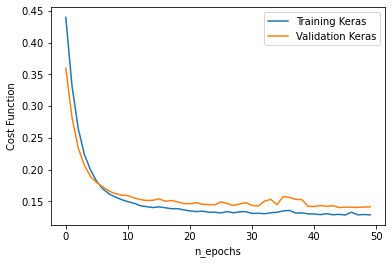

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
Pesos NN Keras
W1 : <tf.Variable 'dense_13/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.8095821 ,  0.9555669 , -0.47587937],
       [-3.4940586 , -2.8731272 ,  3.3718345 ]], dtype=float32)>
W2 : <tf.Variable 'dense_14/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[ 3.578503 ,  5.133452 ],
       [ 2.962067 ,  1.675578 ],
       [-2.7807498, -1.7087277]], dtype=float32)

In [15]:
if __name__ == "__main__":
    ## Open and split data ##
    data = np.genfromtxt('train_data.csv', delimiter=',')
    X_train, X_validation, y_train, y_validation = split(data, 0.8)

    ## Nnet creation ##
    input = fully_connected
    fully_connected_1 = fully_connected
    fully_connected_2 = fully_connected
    output = binary_output
    nnet = [input(2), fully_connected_1(3), fully_connected_2(2), output()]

    ## Hyperparameters##
    lr = 0.01
    n_epochs = 50
    batch_size = 10

    ## Self made model ##
    test = nn(nnet=nnet)
    W, b, J, J_val = test.fit(X_train, y_train, X_validation, y_validation, n_epochs=n_epochs, lr=lr, batch_size=batch_size)
    error = test.predict(X_validation, y_validation)

    ## Keras model ##
    _, in_shape = X_train.shape
    model = Sequential()
    model.add(Dense(3, input_dim=in_shape))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                   loss = keras.losses.MeanAbsoluteError(),
                   metrics =['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=n_epochs, batch_size=batch_size)



    ## Plots ##
    plot = plt.figure(1)
    plt.ylabel('Cost Function')
    plt.xlabel('n_epochs')
    x_plot = np.arange(0, len(J))
    plt.plot(x_plot, J, label=f'Training Self made')
    plt.plot(x_plot, J_val, label=f'Validation Self made')
    plt.legend()
    plt.show()

    ## Weights Comparison ##
    print('Pesos Self Made NN')
    print('W1 :', W[1])
    print('W2 :', W[2])
    print('W3 :', W[3])
    print('b1 :', b[1])
    print('b2 :', b[2])
    print('b3 :', b[3])



    ## Plots ##
    plot = plt.figure(2)
    plt.ylabel('Cost Function')
    plt.xlabel('n_epochs')
    x_plot_k = np.arange(0, len(history.history['loss']))
    plt.plot(x_plot_k, history.history['loss'], label=f'Training Keras')
    plt.plot(x_plot_k, history.history['val_loss'], label=f'Validation Keras')
    plt.legend()
    plt.show()

    model.summary()

    ## Weights comparison ##
    print('Pesos NN Keras')
    print('W1 :', history.model.weights[0])
    print('W2 :', history.model.weights[2])
    print('W3 :', history.model.weights[4])
    print('b1 :', history.model.weights[1])
    print('b2 :', history.model.weights[3])
    print('b3 :', history.model.weights[5])
